<a href="https://colab.research.google.com/github/LesterYe/BAGLS-Image-Segmentation/blob/main/model_mobilenetv2_BAGLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb?force_kitty_mode=1&force_corgi_mode=1"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf

!pip install wandb --upgrade
import wandb
from wandb.keras import WandbCallback, WandbModelCheckpoint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**wandb for monitoring metrics**

In [2]:
key = '1752d2f0785658c328f0ed6d6c0bc7debd495d9c'
wandb.login(key=key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
root = '/content'
proj_dir = '/content/drive/MyDrive/BAGLS-Image-Segmentation/' # Your project directory in Google Drive
# dataset1zip_path = os.path.join(proj_dir,'dataset1.zip')
# dataset1_path = os.path.join(root,'dataset1')
dataset2zip_path = os.path.join(proj_dir,'dataset2.zip')
dataset2_path = os.path.join(root,'dataset2')
# dataset3zip_path = os.path.join(proj_dir,'dataset3.zip')
# dataset3_path = os.path.join(root,'dataset3')

os.chdir(root)
os.getcwd()

'/content'

In [6]:
# !cp '{dataset1zip_path}' .
# !unzip -q dataset1.zip
# !rm dataset1.zip

!cp '{dataset2zip_path}' .
!unzip -q dataset2.zip
!rm dataset2.zip

# !cp '{dataset3zip_path}' .
# !unzip -q dataset3.zip
# !rm dataset3.zip

In [7]:
# _URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
# PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# train_dir = os.path.join(PATH, 'train')
# validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
#                                                             shuffle=True,
#                                                             batch_size=BATCH_SIZE,
#                                                             image_size=IMG_SIZE)

In [ ]:
# validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
#                                                                  shuffle=True,
#                                                                  batch_size=BATCH_SIZE,
#                                                                  image_size=IMG_SIZE)

In [ ]:
# from zmq.sugar.socket import T
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Change the batchsize according to your system RAM
# data_path = dataset1_path
# train_batchsize = 32
# val_batchsize = 32
# train_dir = data_path
# val_dir = data_path

# train_datagen = ImageDataGenerator(
#     rescale = 1./255,
#     horizontal_flip = True,
#     vertical_flip = True,
#     rotation_range = 90,
#     validation_split = 0.2 # set train-val split ratio
# ) 

# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size = (512,256),
#     batch_size = train_batchsize,
#     class_mode = 'categorical',
#     subset = 'training' # set as train data
# )

# val_generator = train_datagen.flow_from_directory(
#     train_dir, # same dir as train data
#     target_size = (512,256),
#     batch_size = val_batchsize,
#     class_mode = 'categorical',
#     subset = 'validation' # set as val data
# )

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset2_path,
    labels='inferred',
    label_mode='int',
    class_names=['normal', 'abnormal'],
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset2_path,
    labels='inferred',
    label_mode='int',
    class_names=['normal', 'abnormal'],
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation'
)

Found 53250 files belonging to 2 classes.
Using 42600 files for training.
Found 53250 files belonging to 2 classes.
Using 10650 files for validation.


Show the first nine images and labels from the training set:

In [ ]:
class_names = train_dataset.class_names
class_names

['normal', 'abnormal']

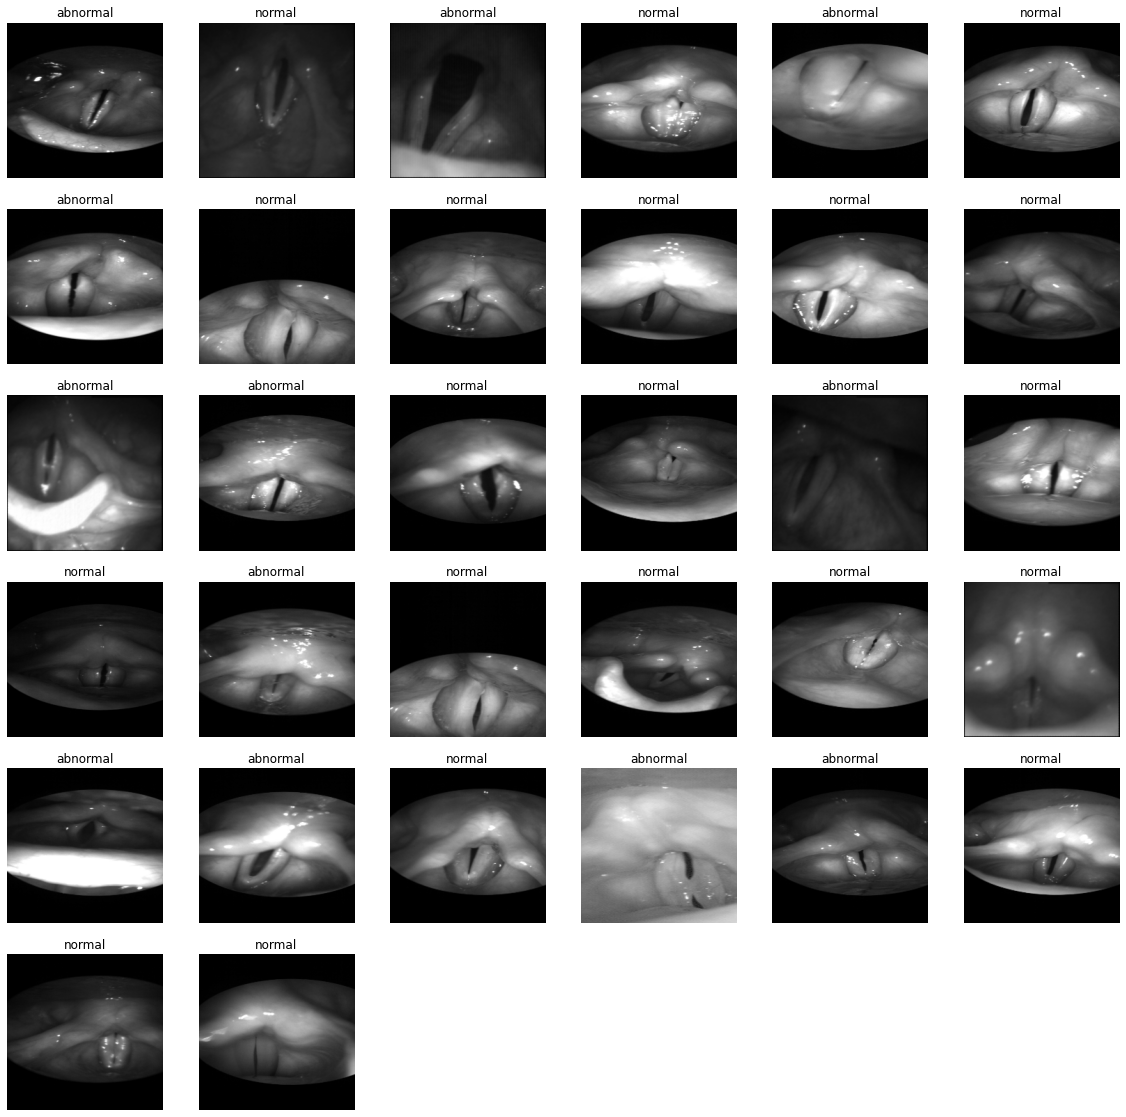

In [ ]:
class_names = train_dataset.class_names
plt.figure(figsize=(20, 20))
for images, labels in train_dataset.take(1):
  for i in range(32):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [ ]:
# val_batches = tf.data.experimental.cardinality(validation_dataset)
# test_dataset = validation_dataset.take(val_batches // 5)
# validation_dataset = validation_dataset.skip(val_batches // 5)

In [9]:
# testset1zip_path = os.path.join(proj_dir,'testset1.zip')
# testset1_path = os.path.join(root,'testset1')

# !cp '{testset1zip_path}' .
# !unzip -q testset1.zip
# !rm testset1.zip

testset2zip_path = os.path.join(proj_dir,'testset2.zip')
testset2_path = os.path.join(root,'testset2')

!cp '{testset2zip_path}' .
!unzip -q testset2.zip
!rm testset2.zip

# testset3zip_path = os.path.join(proj_dir,'testset3.zip')
# testset3_path = os.path.join(root,'testset3')

# !cp '{testset3zip_path}' .
# !unzip -q testset3.zip
# !rm testset3.zip

In [10]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    testset2_path,
    labels='inferred',
    label_mode='int',
    class_names=['normal', 'abnormal'],
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=123,
    validation_split=None,
    subset=None
)

Found 2500 files belonging to 2 classes.


In [ ]:
# print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  # tf.keras.layers.RandomFlip('vertical'),
  tf.keras.layers.RandomRotation(0.2)
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate` or `Model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

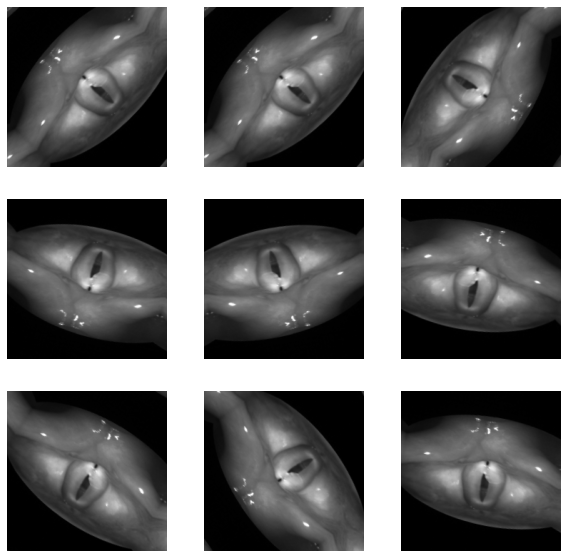

In [13]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[1]

  # print(tf.expand_dims(first_image, 0))
  # break
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [15]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [16]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

(224, 224, 3)
9406464/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [18]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [19]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [21]:
feature_batch

<tf.Tensor: shape=(32, 7, 7, 1280), dtype=float32, numpy=
array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.0081432e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 7.4508458e-01],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 7.3471409e-01, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.3535562e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 8.7524045e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 1.0621409e+00, 3.7242520e+00]

In [22]:
feature_batch_average

<tf.Tensor: shape=(32, 1280), dtype=float32, numpy=
array([[4.8979698e-04, 3.6469203e-01, 0.0000000e+00, ..., 0.0000000e+00,
        2.0390570e-01, 1.4147261e+00],
       [3.3746436e-01, 1.1712680e+00, 0.0000000e+00, ..., 0.0000000e+00,
        2.5983971e-01, 4.9335355e-01],
       [1.3188097e-01, 4.1533569e-01, 0.0000000e+00, ..., 0.0000000e+00,
        4.7996722e-02, 1.1039640e+00],
       ...,
       [2.8759980e-01, 6.4768940e-01, 0.0000000e+00, ..., 2.2386251e-02,
        3.1789103e-01, 1.4170580e+00],
       [4.9691477e-01, 1.3580023e+00, 0.0000000e+00, ..., 0.0000000e+00,
        3.6550739e-01, 5.4642367e-01],
       [4.3351325e-01, 8.8282186e-01, 0.0000000e+00, ..., 0.0000000e+00,
        3.5903713e-01, 2.9744276e-01]], dtype=float32)>

Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [23]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [24]:
prediction_batch

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[-0.95381075],
       [ 0.3056565 ],
       [-0.01549572],
       [-0.16783434],
       [ 0.07199472],
       [ 1.0935478 ],
       [-0.30588678],
       [-0.23345204],
       [-0.40502226],
       [ 0.2573513 ],
       [-0.42347348],
       [-0.10667696],
       [-0.21841061],
       [-0.25406218],
       [ 0.06075969],
       [-0.48008567],
       [ 0.09719585],
       [-0.01613127],
       [-1.0211151 ],
       [ 0.16404152],
       [ 0.10305119],
       [-0.19793975],
       [ 1.0750716 ],
       [-1.2479991 ],
       [-0.00713906],
       [-0.26072222],
       [-0.89098865],
       [-0.15311064],
       [ 0.13946313],
       [-0.43501765],
       [-0.499963  ],
       [-0.57224566]], dtype=float32)>

Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [25]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [26]:
base_learning_rate = 1e-4 # =0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['acc']) # tf.keras.metrics.BinaryAccuracy()

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [28]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [29]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

333/333 [==============================] - 39s 110ms/step - loss: 0.7856 - acc: 0.5446


In [30]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.79
initial accuracy: 0.54


In [31]:
configs = dict(
    data_flag = 'BAGLS_Abnormal_Normal',
    image_width = IMG_SIZE[0], # 224
    image_height = IMG_SIZE[1], # 224
    batch_size = BATCH_SIZE,
    model_name = 'mobilenetv2',
    pretrain_weights = 'imagenet',
    epochs = 20,
    init_learning_rate = 1e-4,
    optimizer = 'Adam',
    loss_fn = 'binary_crossentropy',
    metrics = ['acc'],
    # earlystopping_patience = 5
)

In [32]:
## Using wandb for MLOps
project = 'endoscopy_BAGLS'

wandb.init(project=project, config=configs)

wandb: Currently logged in as: lesterye. Use `wandb login --relogin` to force relogin


In [36]:
# checkpoint_filepath = os.path.join(proj_dir, 'tmp', 'checkpoint') # proj_dir+'/tmp/checkpoint'
checkpoint_filepath = os.path.join(proj_dir, 'mobilenetv2', 'dataset2', 'checkpoint', '20epoch-0.00acc', )

model_checkpoint_callback = WandbModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [ ]:
# # The model weights (that are considered the best) are loaded into the model.
# checkpoint_filepath = os.path.join(proj_dir, 'mobilenetv2', 'checkpoint', '20epoch-0.00acc', )
# model.load_weights(checkpoint_filepath)

In [37]:
callbacks = [
    WandbCallback(),
    model_checkpoint_callback,
    # EarlyStopping(patience=5)
    # ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    # TensorBoard(log_dir='./logs')
]

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    callbacks=callbacks,
                    validation_data=validation_dataset)

Epoch 1/10
1332/1332 [==============================] - ETA: 0s - loss: 0.6483 - acc: 0.6652

wandb: Adding directory to artifact (/content/wandb/run-20221209_091919-3nqkfg7s/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/drive/MyDrive/BAGLS-Image-Segmentation/mobilenetv2/dataset2/checkpoint/20epoch-0.00acc)... Done. 0.1s


1332/1332 [==============================] - 228s 168ms/step - loss: 0.6483 - acc: 0.6652 - val_loss: 0.5952 - val_acc: 0.6840
Epoch 2/10
1331/1332 [============================>.] - ETA: 0s - loss: 0.5900 - acc: 0.6906

wandb: Adding directory to artifact (/content/wandb/run-20221209_091919-3nqkfg7s/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/drive/MyDrive/BAGLS-Image-Segmentation/mobilenetv2/dataset2/checkpoint/20epoch-0.00acc)... Done. 0.1s


1332/1332 [==============================] - 216s 161ms/step - loss: 0.5899 - acc: 0.6906 - val_loss: 0.5699 - val_acc: 0.6963
Epoch 3/10
1331/1332 [============================>.] - ETA: 0s - loss: 0.5684 - acc: 0.6995

wandb: Adding directory to artifact (/content/wandb/run-20221209_091919-3nqkfg7s/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/drive/MyDrive/BAGLS-Image-Segmentation/mobilenetv2/dataset2/checkpoint/20epoch-0.00acc)... Done. 0.1s


1332/1332 [==============================] - 208s 155ms/step - loss: 0.5684 - acc: 0.6995 - val_loss: 0.5590 - val_acc: 0.7126
Epoch 4/10
1331/1332 [============================>.] - ETA: 0s - loss: 0.5558 - acc: 0.7049

wandb: Adding directory to artifact (/content/wandb/run-20221209_091919-3nqkfg7s/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/drive/MyDrive/BAGLS-Image-Segmentation/mobilenetv2/dataset2/checkpoint/20epoch-0.00acc)... Done. 0.1s


1332/1332 [==============================] - 206s 154ms/step - loss: 0.5558 - acc: 0.7049 - val_loss: 0.5520 - val_acc: 0.7216


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

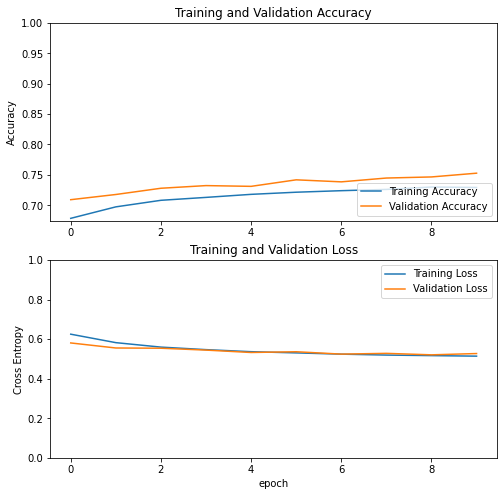

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['acc'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
# configs = dict(
#     data_flag = 'BAGLS_Abnormal_Normal',
#     image_width = IMG_SIZE[0], # 224
#     image_height = IMG_SIZE[1], # 224
#     batch_size = BATCH_SIZE,
#     model_name = 'mobilenetv2',
#     pretrain_weights = 'imagenet',
#     epochs = 20,
#     init_learning_rate = 1e-4,
#     optimizer = 'Adam',
#     loss_fn = 'binary_crossentropy',
#     metrics = ['acc'],
#     # earlystopping_patience = 5
# )

In [ ]:
## Using wandb for MLOps
project = 'endoscopy_BAGLS'

wandb.init(project=project, id='3nqkfg7s', resume="must") # id=run_id, resume="must"

wandb: Currently logged in as: lesterye. Use `wandb login --relogin` to force relogin


In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
1317/1317 [==============================] - 186s 136ms/step - loss: 0.4441 - acc: 0.7770 - val_loss: 0.4422 - val_acc: 0.8349
Epoch 11/20
1317/1317 [==============================] - 174s 132ms/step - loss: 0.3073 - acc: 0.8577 - val_loss: 0.2646 - val_acc: 0.8908
Epoch 12/20
1317/1317 [==============================] - 174s 132ms/step - loss: 0.2085 - acc: 0.9083 - val_loss: 0.1929 - val_acc: 0.9350
Epoch 13/20
1317/1317 [==============================] - 178s 134ms/step - loss: 0.1438 - acc: 0.9405 - val_loss: 0.1760 - val_acc: 0.9445
Epoch 14/20
1317/1317 [==============================] - 174s 132ms/step - loss: 0.0972 - acc: 0.9620 - val_loss: 0.2401 - val_acc: 0.9190
Epoch 15/20
1317/1317 [==============================] - 181s 137ms/step - loss: 0.0655 - acc: 0.9754 - val_loss: 0.1214 - val_acc: 0.9629
Epoch 16/20
1317/1317 [==============================] - 191s 145ms/step - loss: 0.0473 - acc: 0.9829 - val_loss: 0.6591 - val_acc: 0.8025
Epoch 17/20
1317/1317 [====

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [ ]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

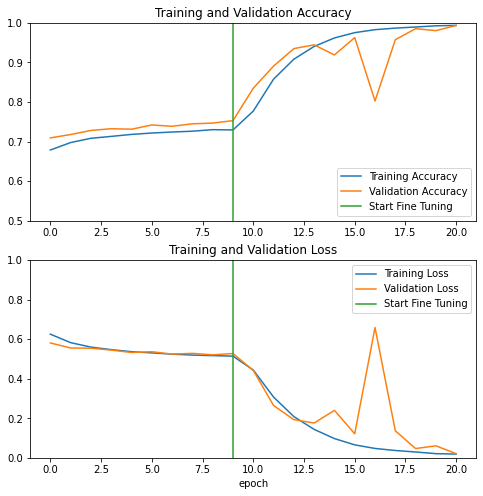

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [ ]:
loss, acc = model.evaluate(test_dataset)
print('Test accuracy :', acc)

72/72 [==============================] - 6s 71ms/step - loss: 1.0098 - acc: 0.8230
Test accuracy : 0.8230434656143188


And now you are all set to use this model to predict if it normal or abnormal.

Predictions:
 [1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 1 1 0]
Labels:
 [1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 0]


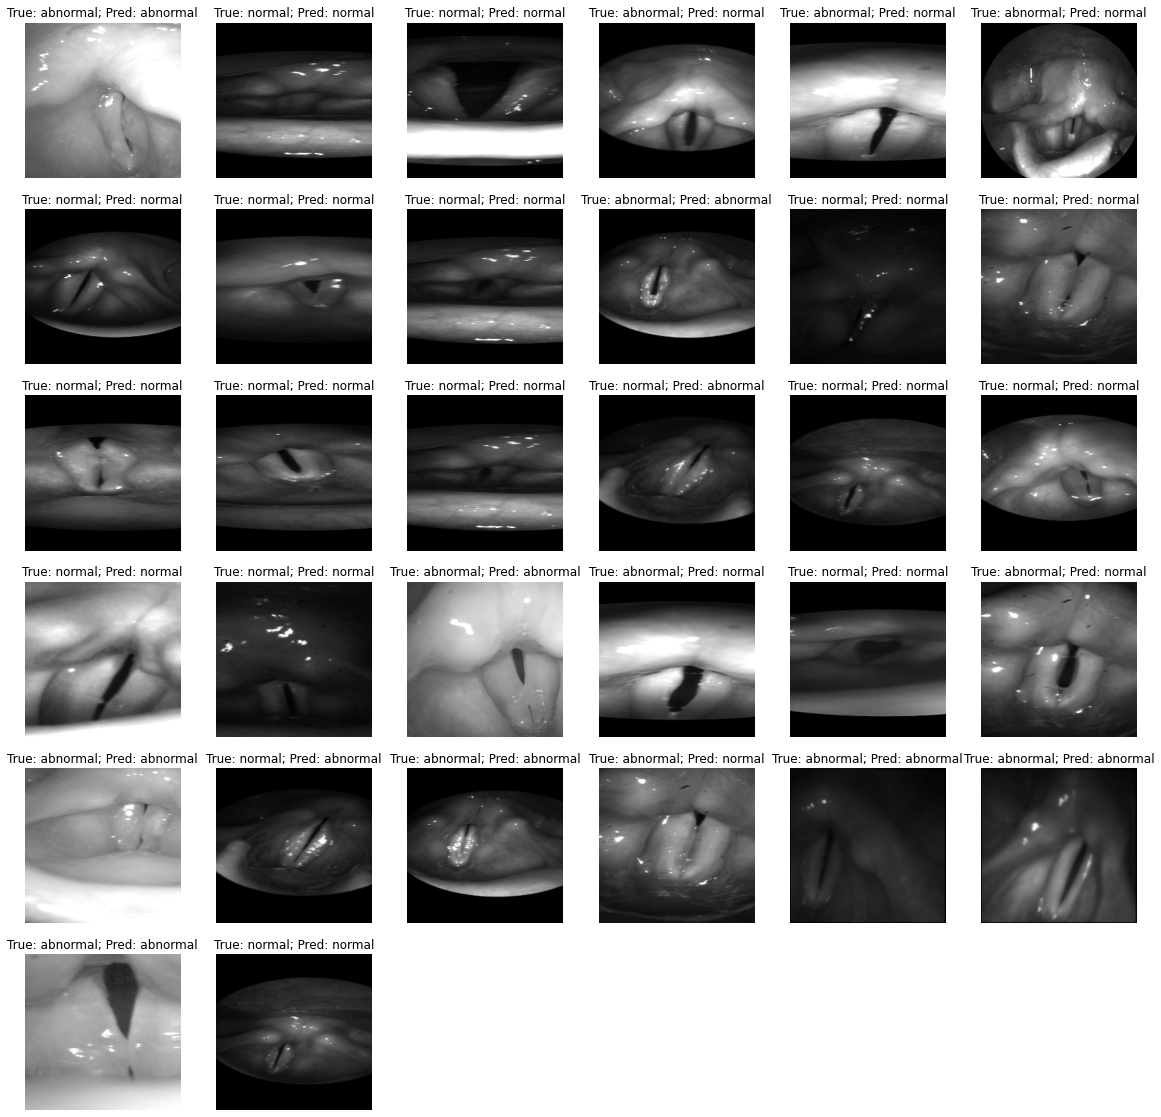

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 20))
for i in range(32):
  ax = plt.subplot(6, 6, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f'True: {class_names[predictions[i]]}; Pred: {class_names[label_batch[i]]}') # class_names[predictions[i]]+''+str(predictions.numpy()[i])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).


In [ ]:
model_save_path = os.path.join(proj_dir, 'mobilenetv2', '20epoch-0.8230acc')
# model.save(model_save_path)

In [ ]:
model = tf.keras.models.load_model(model_save_path)

# Check its architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
# Evaluate the restored model
loss, acc = model.evaluate(test_dataset, verbose=1)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(model.predict(test_dataset).shape)

72/72 [==============================] - 7s 72ms/step - loss: 1.0098 - acc: 0.8230
Restored model, accuracy: 82.30%
72/72 [==============================] - 6s 73ms/step
(2300, 1)


In [ ]:
pred = model.predict(test_dataset)

72/72 [==============================] - 6s 73ms/step


In [ ]:
# Apply a sigmoid since our model returns logits
pred = tf.nn.sigmoid(pred)
pred.numpy()

array([[9.2482513e-01],
       [6.6272810e-02],
       [4.1281706e-01],
       ...,
       [5.0236675e-08],
       [2.2441928e-01],
       [9.9981803e-01]], dtype=float32)

In [ ]:
count_negative = 0
for i in range(len(pred)):
  prob = pred.numpy()[i][0]
  threshold = 0.5
  if prob < threshold:
    count_negative+=1
print(count_negative)

1263


Predictions:
 [0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1]
Labels:
 [0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1]


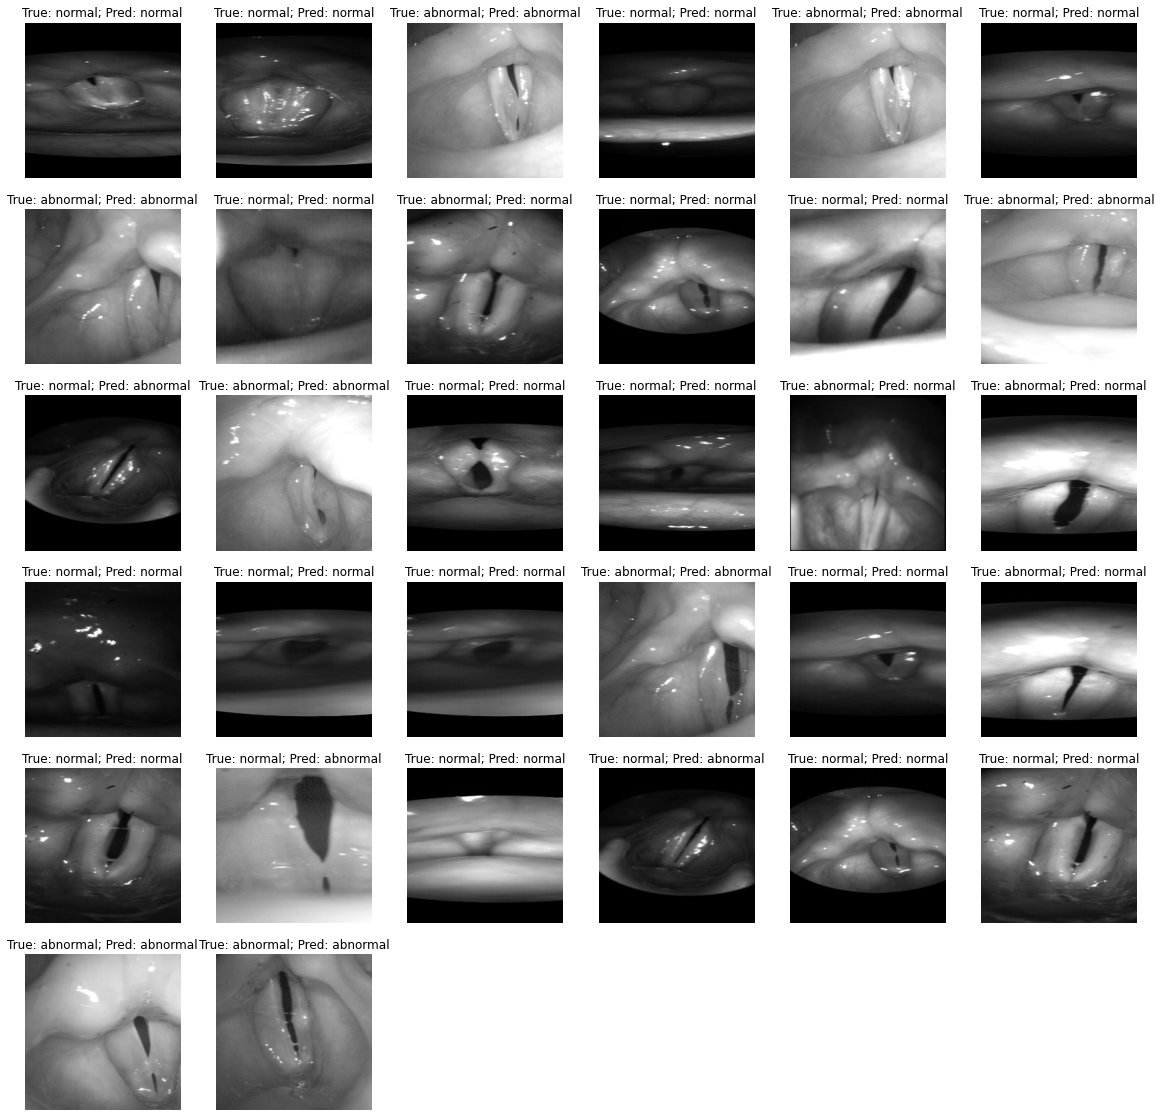

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 20))
for i in range(32):
  ax = plt.subplot(6, 6, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f'True: {class_names[predictions[i]]}; Pred: {class_names[label_batch[i]]}') # class_names[predictions[i]]+''+str(predictions.numpy()[i])
  plt.axis("off")